In [ ]:
!pip3 install rembg onnxruntime pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.1 MB/s eta 0:00:00


In [4]:
import cv2

from PIL import Image
import numpy as np
from io import BytesIO

In [ ]:
from rembg import remove


# Store path of the image in the variable input_path
input_path =  '/content/test11.jpeg'


# Store path of the output image in the variable output_path
output_path = 'output.png'

# Processing the image
input = Image.open(input_path)

# Removing the background from the given Image
output = remove(input)

#Saving the image in the given path
output.save(output_path)

In [5]:
def thresh_image(image, blur_kernel=(5,5)):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, blur_kernel, 0)

    # Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(
        blurred,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        11,
        2
    )

    return thresh

In [6]:
def smart_crop(
    image,
    bbox,
    threshold=0.85,
    min_aspect=2.0,  # favor wider boxes (was 1.5)
    padding_x=65,    # horizontal padding
    padding_y=10     # vertical padding
):
    H, W = image.shape[:2]
    x, y, w, h = bbox

    height_ratio = h / H
    width_ratio = w / W
    aspect = w / h

    # Flag for whether to pad
    apply_padding = True

    # If crop height is too close to image height, reduce height
    if height_ratio > threshold:
        print("Warning: Crop height is too close to original. Reducing height.")
        h = int(H * 0.35)
        y = max(0, y + int((H - h) / 2))
        apply_padding = False

    # Improve aspect ratio: enforce width dominance
    if aspect < min_aspect:
        new_w = int(h * min_aspect)
        x = max(0, x - (new_w - w) // 2)
        w = new_w
        if x + w > W:
            w = W - x

    # Apply asymmetric padding (more horizontal, less vertical)
    if apply_padding:
        x = max(0, x - padding_x)
        w = min(w + 2 * padding_x, W - x)

        y = max(0, y - padding_y)
        h = min(h + 2 * padding_y, H - y)

    return image[y:y+h, x:x+w]

In [101]:
# original btw
def remove_background(img_array: np.ndarray, output_path = 'output.png', color=(0, 0, 0), path = False):

    """
    Removes background, makes it transparent, and colors the foreground (e.g. signature) black.

    Parameters:
    - img_array: Input image as a NumPy array (OpenCV format BGR).
    - output_path: File path to save the processed image.
    - color: RGB tuple for the signature color. Default is black.

    """

    # Convert OpenCV BGR to RGB
    img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    img_rgb = img_array
    pil_image = Image.fromarray(img_rgb)

    # Convert to bytes
    buffer = BytesIO()
    pil_image.save(buffer, format="PNG")
    input_bytes = buffer.getvalue()

    # Step 1: Remove background
    output_image = remove(input_bytes)

    # Step 2: Convert to RGBA PIL Image
    img = Image.open(BytesIO(output_image)).convert("RGBA")

    # Step 3: Convert to numpy array
    data = np.array(img)

    # Step 4: Modify signature color
    r, g, b, a = data.T
    dark_areas = (r < 100) & (g < 100) & (b < 100) & (a > 0)
    data[..., :-1][dark_areas.T] = color

    # Step 5: Convert back to image and save
    result = Image.fromarray(data)
    if path:
      result.save(output_path, format="PNG")
      print(f"Processed image saved to: {output_path}")
    else:
      return result


In [96]:
# I like this better though in some caases

def remove_background2(img_array: np.ndarray, output_path='output.png', color=(64, 64, 64), path = False):
    """
    Removes background, makes it transparent, and forces the foreground (e.g., signature) to black.

    Parameters:
    - img_array: Input image as a NumPy array (OpenCV format BGR).
    - output_path: File path to save the processed image.
    - color: RGB tuple for the signature color. Default is black.
    """
    # Convert OpenCV BGR to RGB
    img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(img_rgb)

    # Convert to bytes
    buffer = BytesIO()
    pil_image.save(buffer, format="PNG")
    input_bytes = buffer.getvalue()

    # Step 1: Remove background
    output_image = remove(input_bytes)

    # Step 2: Convert to RGBA PIL Image
    img = Image.open(BytesIO(output_image)).convert("RGBA")

    # Step 3: Convert to numpy array
    data = np.array(img)

    # Step 4: Force signature to black (or specified color)
    r, g, b, a = data.T
    # Identify the foreground (where alpha is not 0)
    foreground_mask = a > 0
    data[..., :-1][foreground_mask.T] = color  # Set RGB to black for foreground

    # Step 5: Convert back to image and save
    result = Image.fromarray(data)

    if path:
      result.save(output_path, format="PNG")
      print(f"Processed image saved to: {output_path}")
    else:
      return result


In [110]:
import matplotlib.pyplot as plt
def extract_signature(image_path, output_path = None, path = False):

    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not read image at {image_path}")
        return None

    thresh = thresh_image(img)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask for the signature
    mask = np.zeros_like(thresh)

    # Find the largest contour (assumed signature)
    max_area = 0
    main_contour = None


    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 100 and area > max_area:
            max_area = area
            main_contour = contour

    if main_contour is None:
        print("No significant contour found.")
        return None

    # Draw the main signature contour
    cv2.drawContours(mask, [main_contour], -1, 255, -1)

    # Get bounding box of the signature
    bbox = cv2.boundingRect(main_contour)

    # Now crop the image and mask to the bounding box
    cropped_img = smart_crop(img, bbox)

    if output_path is not None and path:
        remove_background(cropped_img, output_path = output_path, path = True)
    else:
        result_image = remove_background(cropped_img)
        plt.imshow(result_image)
        plt.title("Extracted Signature")
        plt.axis('off')  # Turn off axis labels
        plt.show()



In [18]:
from rembg.bg import remove
extract_signature(image_path = '/content/output (1).png')

Processed image saved to: output.png


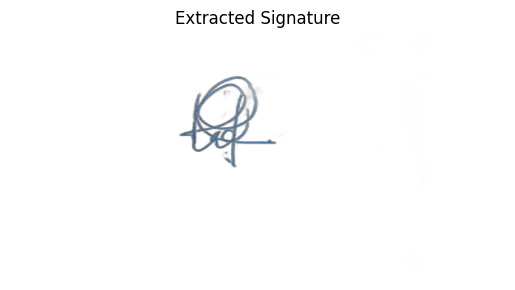

In [106]:
extract_signature('/content/2.jpg')

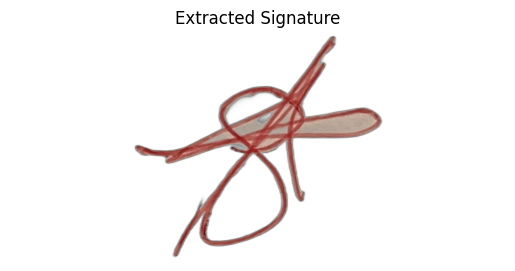

In [108]:
extract_signature('/content/test13.jpeg')

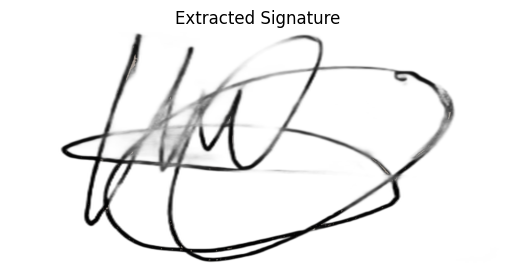

In [113]:
extract_signature('/content/test11.jpeg')

In [111]:
extract_signature('/content/test10.jfif', 'output.png', True)

Processed image saved to: output.png


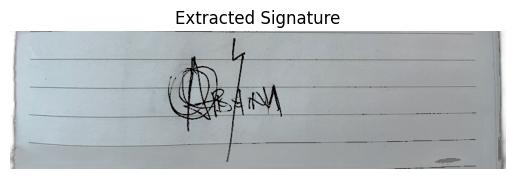

In [107]:
extract_signature('/content/test10.jfif')

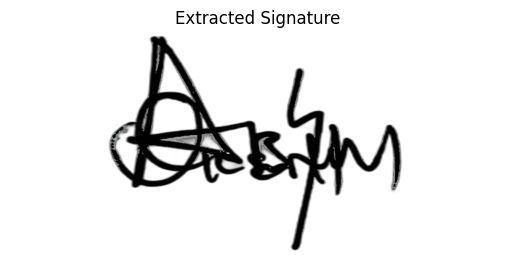

In [112]:
extract_signature('/content/ref.png')